In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import importlib
import os
import pickle
import glob

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, dpi=None):
    plt.figure(dpi=dpi)
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [4]:
Nz = 2**9
rho0_l = 0.2
rho0_s = 0.002
coarse = 8
R_var = 1
Nez = 20
Nex = 500

dz = 1/Nz
z = np.arange(Nz)

Hz = np.eye(Nz)[::4]
Ny = Hz.shape[0]
y = Hz @ z

Nx = Nz // coarse
dx = dz * coarse
Sz2x = np.eye(Nz)[::coarse]
Sx2z = utilities.lin_interp_matrix(Nz, coarse)

Hx = Hz @ Sx2z
x = Sz2x @ z

In [5]:
save_loc = '/Users/harty/Documents/python_code/multi_loc/notebooks/sampling_trials/tune_hetero_sharp'

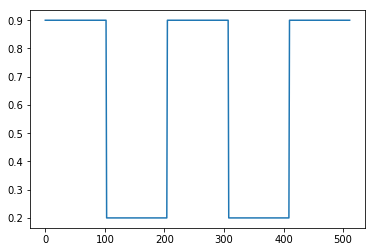

In [6]:
# a_l = 0.6
# Pz = covariance.two_scale_circulant(Nz, dz, rho0_l, rho0_s, a_l, covariance.fft_sqd_exp_1d)
# N_laml = 5

# l_max = 0.9
# l_min = 0.2
# var = 8 * Nz
# zz = np.arange(Nz) - (Nz - 1)/2
# std_l = 1 - np.exp(-(zz)**2/(2 * var))
# std_l = (std_l - std_l.min())/(std_l.max() - std_l.min())
# std_l = std_l * (l_max - l_min) + l_min
# std_l = np.sqrt(std_l)
# Pz = covariance.two_scale_hetero(Nz, dz, rho0_l, rho0_s, covariance.fft_sqd_exp_1d, std_l)
# N_laml = 3


k = 2.5
l_max = 0.9
l_min = 0.2
zz = k* (np.arange(Nz))/Nz * 2 * np.pi
std_l = np.sign(np.sin(zz))
std_l[std_l == 0] = 1
std_l = l_min + (l_max - l_min)/(2) * (std_l + 1)
plt.figure()
plt.plot(std_l)
# Pz = covariance.two_scale_hetero(Nz, dz, rho0_l, rho0_s, covariance.fft_sqd_exp_1d, std_l)
Pz = covariance.two_scale_hetero(Nz, dz, rho0_l, rho0_s, covariance.fft_exp_1d, std_l)
N_laml = 3

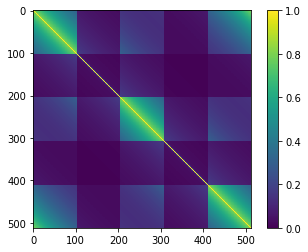

In [7]:
imshow(Pz, vmin=0)

In [8]:
R = R_var * np.eye(Ny)

Lam_z, Qz = np.linalg.eigh(Pz)
Lam_z = Lam_z[::-1]
Qz = Qz[:, ::-1]

Px = Pz[::coarse, ::coarse]
Lam_x, Qx = np.linalg.eigh(Px)
Lam_x = Lam_x[::-1]
Qx = Qx[:, ::-1]

P_sqrtz = Qz @ np.diag(np.sqrt(Lam_z)) @ Qz.T
P_sqrtx = Qx @ np.diag(np.sqrt(Lam_x)) @ Qx.T

In [9]:
num_of_trials = 100
rho0_range1 = np.linspace(0, 0.003, 101)[1:-1]
rho0_range2 = np.linspace(0, 0.3, 101)[1:]
rho0_range = np.concatenate([rho0_range1,
                             rho0_range2])
alpha_range = np.linspace(0, 0.3, 41)
print('Will take: ~', (4)*(num_of_trials), ' minutes')
print('Will take: ~', (4/60)*(num_of_trials), ' hours')
print('rhos: \n', rho0_range)
print('alphas: \n', alpha_range)

Will take: ~ 400  minutes
Will take: ~ 6.666666666666667  hours
rhos: 
 [3.00e-05 6.00e-05 9.00e-05 1.20e-04 1.50e-04 1.80e-04 2.10e-04 2.40e-04
 2.70e-04 3.00e-04 3.30e-04 3.60e-04 3.90e-04 4.20e-04 4.50e-04 4.80e-04
 5.10e-04 5.40e-04 5.70e-04 6.00e-04 6.30e-04 6.60e-04 6.90e-04 7.20e-04
 7.50e-04 7.80e-04 8.10e-04 8.40e-04 8.70e-04 9.00e-04 9.30e-04 9.60e-04
 9.90e-04 1.02e-03 1.05e-03 1.08e-03 1.11e-03 1.14e-03 1.17e-03 1.20e-03
 1.23e-03 1.26e-03 1.29e-03 1.32e-03 1.35e-03 1.38e-03 1.41e-03 1.44e-03
 1.47e-03 1.50e-03 1.53e-03 1.56e-03 1.59e-03 1.62e-03 1.65e-03 1.68e-03
 1.71e-03 1.74e-03 1.77e-03 1.80e-03 1.83e-03 1.86e-03 1.89e-03 1.92e-03
 1.95e-03 1.98e-03 2.01e-03 2.04e-03 2.07e-03 2.10e-03 2.13e-03 2.16e-03
 2.19e-03 2.22e-03 2.25e-03 2.28e-03 2.31e-03 2.34e-03 2.37e-03 2.40e-03
 2.43e-03 2.46e-03 2.49e-03 2.52e-03 2.55e-03 2.58e-03 2.61e-03 2.64e-03
 2.67e-03 2.70e-03 2.73e-03 2.76e-03 2.79e-03 2.82e-03 2.85e-03 2.88e-03
 2.91e-03 2.94e-03 2.97e-03 3.00e-03 6.00e-03 9.00e-

In [10]:
if not os.path.exists(save_loc):
    os.mkdir(save_loc)
init_params = {'Pz': Pz, 'Pz_sqrt': P_sqrtz,
               'Nez': Nez, 'Hz': Hz,
               'Px': Px, 'Px_sqrt': P_sqrtx,
               'Nex': Nex, 'Sz2x': Sz2x,
               'R': R}

tune_params = {'rho0': rho0_range,
               'alpha': alpha_range}

# homo_params = {'Nz': Nz,
#                'rho0_l': rho0_l,
#                'rho0_s': rho0_s,
#                'coarse': coarse,
#                'R_var': R_var,
#                'a_l': a_l}
# this_path = os.path.join(save_loc, 'homo_params.pkl')
# with open(this_path, mode='wb') as f:
#     pickle.dump(homo_params, f)

# hetero_params = {'Nz': Nz,
#                  'rho0_l': rho0_l,
#                  'rho0_s': rho0_s,
#                  'coarse': coarse,
#                  'R_var': R_var,
#                  'rho0_l': rho0_l,
#                  'l_max': l_max,
#                  'l_min': l_min,
#                  'var': var}
# this_path = os.path.join(save_loc, 'hetero_params.pkl')
# with open(this_path, mode='wb') as f:
#     pickle.dump(hetero_params, f)

sharp_hetero_params = {
    'Nz': Nz,
    'rho0_l': rho0_l,
    'rho0_s': rho0_s,
    'coarse': coarse,
    'R_var': R_var,
    'rho0_l': rho0_l,
    'l_max': l_max,
    'l_min': l_min,
    'k': k}
this_path = os.path.join(save_loc, 'hetero_params.pkl')
with open(this_path, mode='wb') as f:
    pickle.dump(sharp_hetero_params, f)

if not os.path.exists(save_loc):
    os.mkdir(save_loc)
this_path = os.path.join(save_loc, 'Pz')
np.save(this_path, Pz)
this_path = os.path.join(save_loc, 'Qz')
np.save(this_path, Qz)
this_path = os.path.join(save_loc, 'Hz')
np.save(this_path, Hz)
this_path = os.path.join(save_loc, 'R')
np.save(this_path, R)
this_path = os.path.join(save_loc, 'Sz2x')
np.save(this_path, Sz2x)
this_path = os.path.join(save_loc, 'Sx2z')
np.save(this_path, Sx2z)
this_path = os.path.join(save_loc, 'tune_params.pkl')
with open(this_path, mode='wb') as f:
    pickle.dump(tune_params, f)
    
this_path = os.path.join(save_loc, 'N_laml')
np.save(this_path, N_laml)

In [11]:
  
def init_trial_data(*, load_path=None, Nez=None, Pz=None, Pz_sqrt=None,
                    R=None, Hz=None, Nex=None, Px=None, Px_sqrt=None, Sz2x=None):
    if load_path is not None:
        this_path = os.path.join(load_path, 'mu_z.npy')
        mu_z = np.load(this_path)
        this_path = os.path.join(load_path, 'Zens.npy')
        Zens = np.load(this_path)
        this_path = os.path.join(load_path, 'Zobs.npy')
        Zobs = np.load(this_path)
        
        this_path = os.path.join(load_path, 'mu_x.npy')
        mu_x = np.load(this_path)
        this_path = os.path.join(load_path, 'Xens.npy')
        Xens = np.load(this_path)
        
    else:
        mu_z = np.random.multivariate_normal(np.zeros(Nz), Pz)
        Zens = assimilate.generate_ensemble(Nez, mu_z, Pz_sqrt)
        Zobs = Hz @ mu_z
        Ny = Zobs.size
        Zobs = (Zobs[:, None]
                + np.random.multivariate_normal(
                    np.zeros(Ny), R, Nez).T)
        mu_x = Sz2x @ mu_z
        Xens = assimilate.generate_ensemble(Nex, mu_x, Px_sqrt)
    Pz_sam = np.cov(Zens)
    Px_sam = np.cov(Xens)
    data_dict = {'mu_z': mu_z,
                 'Zens': Zens,
                 'Pz_sam': Pz_sam,
                 'Zobs': Zobs,
                 'mu_x': mu_x,
                 'Xens': Xens,
                 'Px_sam': Px_sam}
    return data_dict
        

def assimilate_stdrd(Zens, Zobs, Hz, R, Pz_sam, rho0, alpha):
    Pz_sam_copy = Pz_sam.copy()
    Zens_copy = Zens.copy()
    mu_sam = Zens_copy.mean(axis=1)
    Zens_copy -= mu_sam[:, None]
    Zens_copy *= np.sqrt(1 + alpha)
    Zens_copy += mu_sam[:, None]
    Pz_sam_copy *= (1 + alpha)
    Nz = mu_sam.size
    dz = 1/Nz
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = L_s * Pz_sam_copy
    Za = KF(Zens_copy, Zobs, Pz_loc, Hz, R)
    return Za


def assimilate_eig(Zens, Zobs,
                   Hz, R, Pz_Qzl,
                   Pz_orth, Proj,
                   rho0, alpha):
    Zens_copy = Zens.copy()
    Nz = Zens_copy.shape[0]
    dz = 1/Nz
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = Pz_Qzl + Proj @ (L_s * Pz_orth) @ Proj
    mu_sam = Zens_copy.mean(axis=1)
    Zens_copy -= mu_sam[:, None]
    Zens_copy *= np.sqrt(1 + alpha)
    Zens_copy += mu_sam[:, None]
    Pz_loc *= (1 + alpha)
    Za = KF(Zens_copy, Zobs, Pz_loc, Hz, R)
    return Za
    
    
def KF(Z, Zobs, Pz, H, R):
    K = Pz @ H.T @ np.linalg.pinv(H @ Pz @ H.T + R)
    Za = Z + K @ (Zobs - H @ Z)
    return Za

In [12]:
rmse_stdrd = np.ones([num_of_trials,
                      alpha_range.size,
                      rho0_range.size]) * np.nan
std_stdrd = rmse_stdrd.copy()
alpha_array = rmse_stdrd.copy()
rho0_array = rmse_stdrd.copy()

rmse_Pz = np.ones([num_of_trials]) * np.nan
std_Pz = rmse_Pz.copy()
rmse_Qz = rmse_Pz.copy()
std_Qz = rmse_Pz.copy()
rmse_sam = rmse_Pz.copy()
std_sam = rmse_Pz.copy()

rmse_eig = rmse_stdrd.copy()
std_eig = rmse_eig.copy()
alpha_array = rmse_eig.copy()
rho0_array = rmse_eig.copy() 

for trial_count in range(num_of_trials):
    print(f'trial_{trial_count:04}')
    trial_dir = os.path.join(save_loc, f'trial_{trial_count:04}')
    if not os.path.exists(trial_dir):
        os.mkdir(trial_dir)
    trial_data = init_trial_data(**init_params)
    for key, value in trial_data.items():
        this_file = os.path.join(trial_dir, key)
        np.save(this_file, value)
    Zens = trial_data['Zens']
    Zobs = trial_data['Zobs']
    Pz_sam = trial_data['Pz_sam']
    mu_z = trial_data['mu_z']
    
    # Using true Pz
    Zens_a = KF(Zens, Zobs, Pz, Hz, R)
    this_mu = np.mean(Zens_a, axis=1)
    this_rmse = np.sqrt(((mu_z - this_mu)**2).mean())
    this_path = os.path.join(trial_dir, 'rmse_Pz')
    np.save(this_path, this_rmse)
    rmse_Pz[trial_count] = this_rmse
    this_std = np.sqrt(Zens_a.var(axis=1).mean())
    this_path = os.path.join(trial_dir, 'std_Pz')
    np.save(this_path, this_std)
    std_Pz[trial_count] = this_std
    
    # Using true Qz
    Pz_Qz = (Qz
             @ np.diag(np.diag(
                 Qz.T @ Pz_sam @ Qz))
             @ Qz.T)
    Zens_a = KF(Zens, Zobs, Pz_Qz, Hz, R)
    this_mu = np.mean(Zens_a, axis=1)
    this_rmse = np.sqrt(((mu_z - this_mu)**2).mean())
    this_path = os.path.join(trial_dir, 'rmse_Qz')
    np.save(this_path, this_rmse)
    rmse_Qz[trial_count] = this_rmse
    this_std = np.sqrt(Zens_a.var(axis=1).mean())
    this_path = os.path.join(trial_dir, 'std_Qz')
    np.save(this_path, this_std)
    std_Qz[trial_count] = this_std
    
    # Using sample 
    Zens_a = KF(Zens, Zobs, Pz_sam, Hz, R)
    this_mu = np.mean(Zens_a, axis=1)
    this_rmse = np.sqrt(((mu_z - this_mu)**2).mean())
    this_path = os.path.join(trial_dir, 'rmse_sam')
    np.save(this_path, this_rmse)
    rmse_sam[trial_count] = this_rmse
    this_std = np.sqrt(Zens_a.var(axis=1).mean())
    this_path = os.path.join(trial_dir, 'std_sam')
    np.save(this_path, this_std)
    std_sam[trial_count] = this_std
    
    # Calculations for eig loc
    Px_sam = trial_data['Px_sam']
    Lam_xsam, Qxsam = np.linalg.eigh(Px_sam)
    Lam_xsam = Lam_xsam[::-1]
    Qxsam = Qxsam[:, ::-1]
    Qzl_sam = Qxsam[:, :N_laml]
    Qzl_sam = utilities.upscale_on_loop(Qzl_sam.T, coarse)
    Qzl_sam = Qzl_sam.T
    Qzl_sam, temp = np.linalg.qr(Qzl_sam)
    Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T
    Lam_zl_sam = np.diag(Qzl_sam.T @ Pz_sam @ Qzl_sam)
    Pz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T
    Pz_orth_sam = Proj_sam @ Pz_sam @ Proj_sam

    for alpha_count, this_alpha in enumerate(alpha_range):
        print(f'{alpha_count}', end=';')
        for rho0_count, this_rho0 in enumerate(rho0_range):
            # using stdrd localization
            Zens_a = assimilate_stdrd(Zens, Zobs,
                                      Hz, R, Pz_sam,
                                      this_rho0, this_alpha)
            
            mu_sam = Zens_a.mean(axis=1)
            this_rmse = np.sqrt(((mu_z - mu_sam)**2).mean())
            this_std = np.sqrt(Zens_a.var(axis=1).mean())
            
            rmse_stdrd[trial_count, alpha_count, rho0_count] = this_rmse
            std_stdrd[trial_count, alpha_count, rho0_count] = this_std
            alpha_array[trial_count, alpha_count, rho0_count] = this_alpha
            rho0_array[trial_count, alpha_count, rho0_count] = this_rho0
            
            # using eig localization
            Zens_a = assimilate_eig(Zens, Zobs,
                                    Hz, R, Pz_Qsam,
                                    Pz_orth_sam, Proj_sam,
                                    this_rho0, this_alpha)
            
            this_mu = np.mean(Zens_a, axis=1)
            this_rmse = np.sqrt(((mu_z - this_mu)**2).mean())
            this_std = np.sqrt(Zens_a.var(axis=1).mean())
            
            rmse_eig[trial_count, alpha_count, rho0_count] = this_rmse
            std_eig[trial_count, alpha_count, rho0_count] = this_std
    print()
    this_path = os.path.join(trial_dir, 'rmse_stdrd')
    np.save(this_path, rmse_stdrd[trial_count])
    
    this_path = os.path.join(trial_dir, 'std_stdrd')
    np.save(this_path, std_stdrd[trial_count])
    
    this_path = os.path.join(trial_dir, 'rmse_eig')
    np.save(this_path, rmse_eig[trial_count])
    
    this_path = os.path.join(trial_dir, 'std_eig')
    np.save(this_path, std_eig[trial_count])
    
    this_path = os.path.join(trial_dir, 'alpha_array')
    np.save(this_path, alpha_array[trial_count])
    
    this_path = os.path.join(trial_dir, 'rho0_array')
    np.save(this_path, rho0_array[trial_count])

trial_0000
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0001
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0002
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0003
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0004
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0005
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0006
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0007
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;


0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0066
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0067
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0068
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0069
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0070
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0071
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0072
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;
trial_0073


In [13]:
search_path = os.path.join(save_loc, 'trial_*')
trial_dirs = glob.glob(search_path)
num_of_trials = len(trial_dirs)

this_path = os.path.join(trial_dirs[0], 'alpha_array.npy')
this_alpha_array = np.load(this_path)
alpha_range_size, rho0_range_size = this_alpha_array.shape

rmse_stdrd = np.ones([num_of_trials, alpha_range_size, rho0_range_size]) * np.nan
std_stdrd = rmse_stdrd.copy()
alpha_array = rmse_stdrd.copy()
rho0_array = rmse_stdrd.copy()

rmse_eig = rmse_stdrd.copy()
std_eig = rmse_stdrd.copy()
alpha_array = rmse_stdrd.copy()
rho0_array = rmse_stdrd.copy()

rmse_Pz = np.ones([num_of_trials]) * np.nan
std_Pz = rmse_Pz.copy()
rmse_Qz = rmse_Pz.copy()
std_Qz = rmse_Pz.copy()
rmse_sam = rmse_Pz.copy()
std_sam = rmse_Pz.copy()

for trial_count in range(num_of_trials):
    print(f'trial_{trial_count:04}')
    trial_dir = os.path.join(save_loc, f'trial_{trial_count:04}')
    
    this_path = os.path.join(trial_dir, 'rmse_stdrd.npy')
    rmse_stdrd[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'std_stdrd.npy')
    std_stdrd[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'rmse_eig.npy')
    rmse_eig[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'std_eig.npy')
    std_eig[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'alpha_array.npy')
    alpha_array[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'rho0_array.npy')
    rho0_array[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'rmse_Pz.npy')
    rmse_Pz[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'std_Pz.npy')
    std_Pz[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'rmse_Qz.npy')
    rmse_Qz[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'std_Qz.npy')
    std_Qz[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'rmse_sam.npy')
    rmse_sam[trial_count] = np.load(this_path)
    
    this_path = os.path.join(trial_dir, 'std_sam.npy')
    std_sam[trial_count] = np.load(this_path)
    
#     this_path = os.path.join(trial_dir, 'rmse_smooth')
#     rmse_smooth = np.load(this_path) 
    
#     this_path = os.path.join(trial_dir, 'std_smooth')
#     std_smooth = np.load(this_path)

trial_0000
trial_0001
trial_0002
trial_0003
trial_0004
trial_0005
trial_0006
trial_0007
trial_0008
trial_0009
trial_0010
trial_0011
trial_0012
trial_0013
trial_0014
trial_0015
trial_0016
trial_0017
trial_0018
trial_0019
trial_0020
trial_0021
trial_0022
trial_0023
trial_0024
trial_0025
trial_0026
trial_0027
trial_0028
trial_0029
trial_0030
trial_0031
trial_0032
trial_0033
trial_0034
trial_0035
trial_0036
trial_0037
trial_0038
trial_0039
trial_0040
trial_0041
trial_0042
trial_0043
trial_0044
trial_0045
trial_0046
trial_0047
trial_0048
trial_0049
trial_0050
trial_0051
trial_0052
trial_0053
trial_0054
trial_0055
trial_0056
trial_0057
trial_0058
trial_0059
trial_0060
trial_0061
trial_0062
trial_0063
trial_0064
trial_0065
trial_0066
trial_0067
trial_0068
trial_0069
trial_0070
trial_0071
trial_0072
trial_0073
trial_0074
trial_0075
trial_0076
trial_0077
trial_0078
trial_0079
trial_0080
trial_0081
trial_0082
trial_0083
trial_0084
trial_0085
trial_0086
trial_0087
trial_0088
trial_0089
trial_0090

In [14]:
ratio_eig = rmse_eig/std_eig
ave_rmse_eig = np.sqrt((rmse_eig**2).mean(axis=0))
ave_std_eig = np.sqrt((std_eig**2).mean(axis=0))
ave_ratio_eig = np.sqrt((ratio_eig**2).mean(axis=0))
min_index_eig = np.unravel_index(np.argmin(ave_rmse_eig), (ave_rmse_eig.shape))
print('optimal values for eig localization')
print('rmse: ', ave_rmse_eig[min_index_eig])
print('rho0: ', rho0_array[0][min_index_eig])
print('alpha: ', alpha_array[0][min_index_eig])

optimal values for eig localization
rmse:  0.16328875856164063
rho0:  0.006
alpha:  0.0


In [16]:
search_path = os.path.join(save_loc, 'trial_*')
trial_dirs = glob.glob(search_path)
num_of_trials = len(trial_dirs)

smooth_range = np.linspace(0, 50, 101)
smooth_array = np.repeat(smooth_range[None, :], num_of_trials, axis=0)

rmse_smooth = smooth_array.copy()
std_smooth = smooth_array.copy()

rho0_smooth = rho0_array[0][min_index_eig]
alpha_smooth = alpha_array[0][min_index_eig]

this_path = os.path.join(save_loc, 'smooth_array')
np.save(this_path, smooth_array)

this_path = os.path.join(save_loc, 'rho0_smooth')
np.save(this_path, rho0_smooth)

this_path = os.path.join(save_loc, 'alpha_smooth')
np.save(this_path, alpha_smooth)

this_path = os.path.join(save_loc, 'N_laml.npy')
N_laml = np.load(this_path)

this_path = os.path.join(save_loc, 'Hz.npy')
Hz = np.load(this_path)

this_path = os.path.join(save_loc, 'R.npy')
R = np.load(this_path)
Nz = Hz.shape[1]


for trial_count in range(num_of_trials):
    print(f'trial_{trial_count:04}')
    trial_dir = os.path.join(save_loc, f'trial_{trial_count:04}')
    this_path = os.path.join(trial_dir, 'Zens.npy')
    Zens = np.load(this_path)
    this_path = os.path.join(trial_dir, 'Zobs.npy')
    Zobs = np.load(this_path)
    this_path = os.path.join(trial_dir, 'Pz_sam.npy')
    Pz_sam = np.load(this_path)
    this_path = os.path.join(trial_dir, 'mu_z.npy')
    mu_z = np.load(this_path)
    for smooth_count, this_smooth in enumerate(smooth_range):
        print(smooth_count, end=';')
        Zens_copy = Zens.copy()
        if this_smooth > 0:
            Zens_smooth = ndimage.gaussian_filter1d(Zens_copy, this_smooth, axis=0, mode='wrap')
        else:
            Zens_smooth = Zens_copy
        Pz_sam_smooth = np.cov(Zens_smooth)
        Lam_zsmooth, Qzsmooth = np.linalg.eigh(Pz_sam_smooth)
        Lam_zsmooth = Lam_zsmooth[::-1]
        Qzsmooth = Qzsmooth[:, ::-1]
        Qzl_sam = Qzsmooth[:, :N_laml]
        Qzl_sam, temp = np.linalg.qr(Qzl_sam)
        Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T
        Lam_zl_sam = np.diag(Qzl_sam.T @ Pz_sam @ Qzl_sam)
        Pz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T
        Pz_orth_sam = Proj_sam @ Pz_sam @ Proj_sam
        
        Zens_a = assimilate_eig(Zens, Zobs,
                                Hz, R, Pz_Qsam,
                                Pz_orth_sam, Proj_sam,
                                rho0_smooth, alpha_smooth)

        this_mu = np.mean(Zens_a, axis=1)
        this_rmse = np.sqrt(((mu_z - this_mu)**2).mean())
        this_std = np.sqrt(Zens_a.var(axis=1).mean())

        rmse_smooth[trial_count, smooth_count] = this_rmse
        std_smooth[trial_count, smooth_count] = this_std
    print()
    this_path = os.path.join(trial_dir, 'rmse_smooth')
    np.save(this_path, rmse_smooth[trial_count])

    this_path = os.path.join(trial_dir, 'std_smooth')
    np.save(this_path, std_smooth[trial_count])

trial_0000
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0001
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0002
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0003
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;

0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0027
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0028
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0029
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30

0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0053
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0054
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0055
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30

0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0079
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0080
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;98;99;100;
trial_0081
0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30